# Healthcare Final Project
- Darshil Desai, Edwin Ramirez, Rashi Saxena

(D)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

# 1. Project Overview

- Regression: Predict post_medical_cost
- Classifications - Logistic, KNN and NB: to predict pdc_80_flag

# 2. Exploring the Dataset

In [2]:
# Reading in the data file
data = pd.read_csv('projectTrain.csv')
data.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
2,0.938889,0,0,7,0,11,4,8.600000,1.000000,0,...,179.538533,0.000000,1.000000,11,0,171.446621,0.000000,1.000000,1,*ANTICOAGULANTS*
3,0.077778,1,12,40,0,5,5,2.033333,1.000000,1,...,105.816329,0.000000,1.000000,5,0,335.826436,0.000000,1.000000,0,*ANTICOAGULANTS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*


In [3]:
# Taking a look at the data dimensions
print ('This dataset has {} records and {} features'.format(data.shape[0], data.shape[1]))

This dataset has 2000 records and 94 features


In [41]:
# Features in focus
print ('Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag' )

Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag


### Taking a look at our predictor variables

C:\Users\saxen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


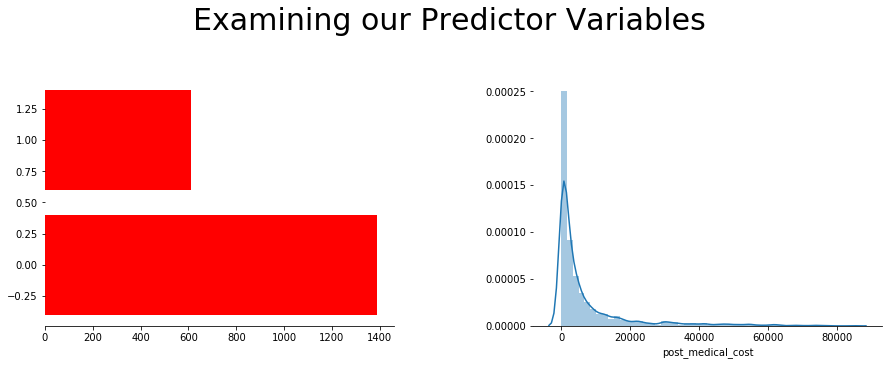

In [39]:
# Taking a look at our predictor variables

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Examining our Predictor Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,1)

a = pd.DataFrame(data.groupby(data.pdc_80_flag)['pdc_80_flag'].count())
plt.barh(list(a.index),a.pdc_80_flag, color = 'red')

#-------------------------------------------
# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,2)
sns.distplot(data['post_medical_cost'], label="Actual High")


sns.despine(left=True)


### Subsetting our independant variables

In this section we will subset the dataframe and select the features we deem appropriate to further this analysis. Note that these features are not final and among these features there will be several that will not be selected for the machine learning models. In the "Feature Selection" section of this project, we will employ the use of various statistical techniques to determine the appropriateness of the same. 

In [16]:
data.dtypes

pdc                        float64
num_ip_post                  int64
total_los_post               int64
num_op_post                  int64
num_er_post                  int64
num_ndc_post                 int64
num_gpi6_post                int64
adjust_total_30d_post      float64
generic_rate_post          float64
post_ip_flag                 int64
post_er_flag                 int64
pdc_cat                      int64
post_ip_cost               float64
post_er_cost               float64
post_rx_cost               float64
post_op_cost               float64
post_total_cost            float64
post_medical_cost          float64
idx_copay                  float64
age_grpN                     int64
sexN                         int64
regionN                      int64
idx_prodtypeN                int64
idx_paytypN                  int64
age_cat                      int64
log_idx_copay              float64
ALCOHOL_DRUG                 int64
ASTHMA                       int64
CARDIAC_ARRYTHMIA   

##### Continuous variables 
- num_ip
- num_op
- num_er
- num_ndc
- generic_rate_post

##### Categorical variables 
- All diseases
- Age group
- sex

In [7]:
""" Subsetting the dataset to account for diabetic patients only """

data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]
data1.head(10)

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*
15,0.900000,0,0,7,0,37,12,36.000000,0.627778,0,...,452.943021,3239.094592,0.122681,25,12,376.675746,5461.857232,0.064515,1,*ANTIDIABETICS*
17,0.500000,0,0,2,0,13,4,11.500000,0.478261,0,...,165.140283,0.000000,1.000000,7,6,360.222309,1881.925575,0.160659,0,*ANTIDIABETICS*
18,0.827778,0,0,0,0,49,13,47.133333,0.877652,0,...,1057.056502,1544.676848,0.406289,42,7,1569.525523,2133.939243,0.423799,1,*ANTIDIABETICS*
19,0.883333,0,0,13,0,10,4,6.733333,1.000000,0,...,26.272804,0.000000,1.000000,10,0,103.186550,0.000000,1.000000,1,*ANTIDIABETICS*
20,0.327778,0,0,8,0,3,2,2.166667,1.000000,0,...,134.296431,0.000000,1.000000,3,0,30.374082,0.000000,1.000000,0,*ANTIDIABETICS*
21,0.500000,0,0,6,0,13,4,11.666667,0.228571,0,...,67.722973,1647.333224,0.039487,4,9,33.007475,1845.994063,0.017566,0,*ANTIDIABETICS*
23,0.805556,0,0,10,0,25,10,22.766667,0.468521,0,...,55.292547,2178.052244,0.024758,12,13,202.702337,2982.013656,0.063648,1,*ANTIDIABETICS*


In [56]:
"""Creating the Continous variables"""
first_cont = data1.iloc[:,0:19]
other_cont = data1.iloc[:,62:92]

cont_features = pd.concat([first_cont,other_cont ],axis=1)
cont_features.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,2,13,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,17,0,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,9,11,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669
15,0.900000,0,0,7,0,37,12,36.000000,0.627778,0,...,16,14,452.943021,3239.094592,0.122681,25,12,376.675746,5461.857232,0.064515
17,0.500000,0,0,2,0,13,4,11.500000,0.478261,0,...,6,0,165.140283,0.000000,1.000000,7,6,360.222309,1881.925575,0.160659


In [36]:
cont_features.shape

(965, 51)

In [28]:
"""Creating our categorical variables"""

all_diseases = data1.iloc[:,26:61]
othercats = data1.iloc[:,19:22]

cat_features = pd.concat([all_diseases,othercats ],axis=1)
cat_features.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,THYROID,Solid_Tumor,Metastatic,Leukemia_Lymphoma,Other_Cancer,Cancer_In_Situ,pre_CCI,age_grpN,sexN,regionN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,3


In [37]:
cat_features.shape

(965, 38)

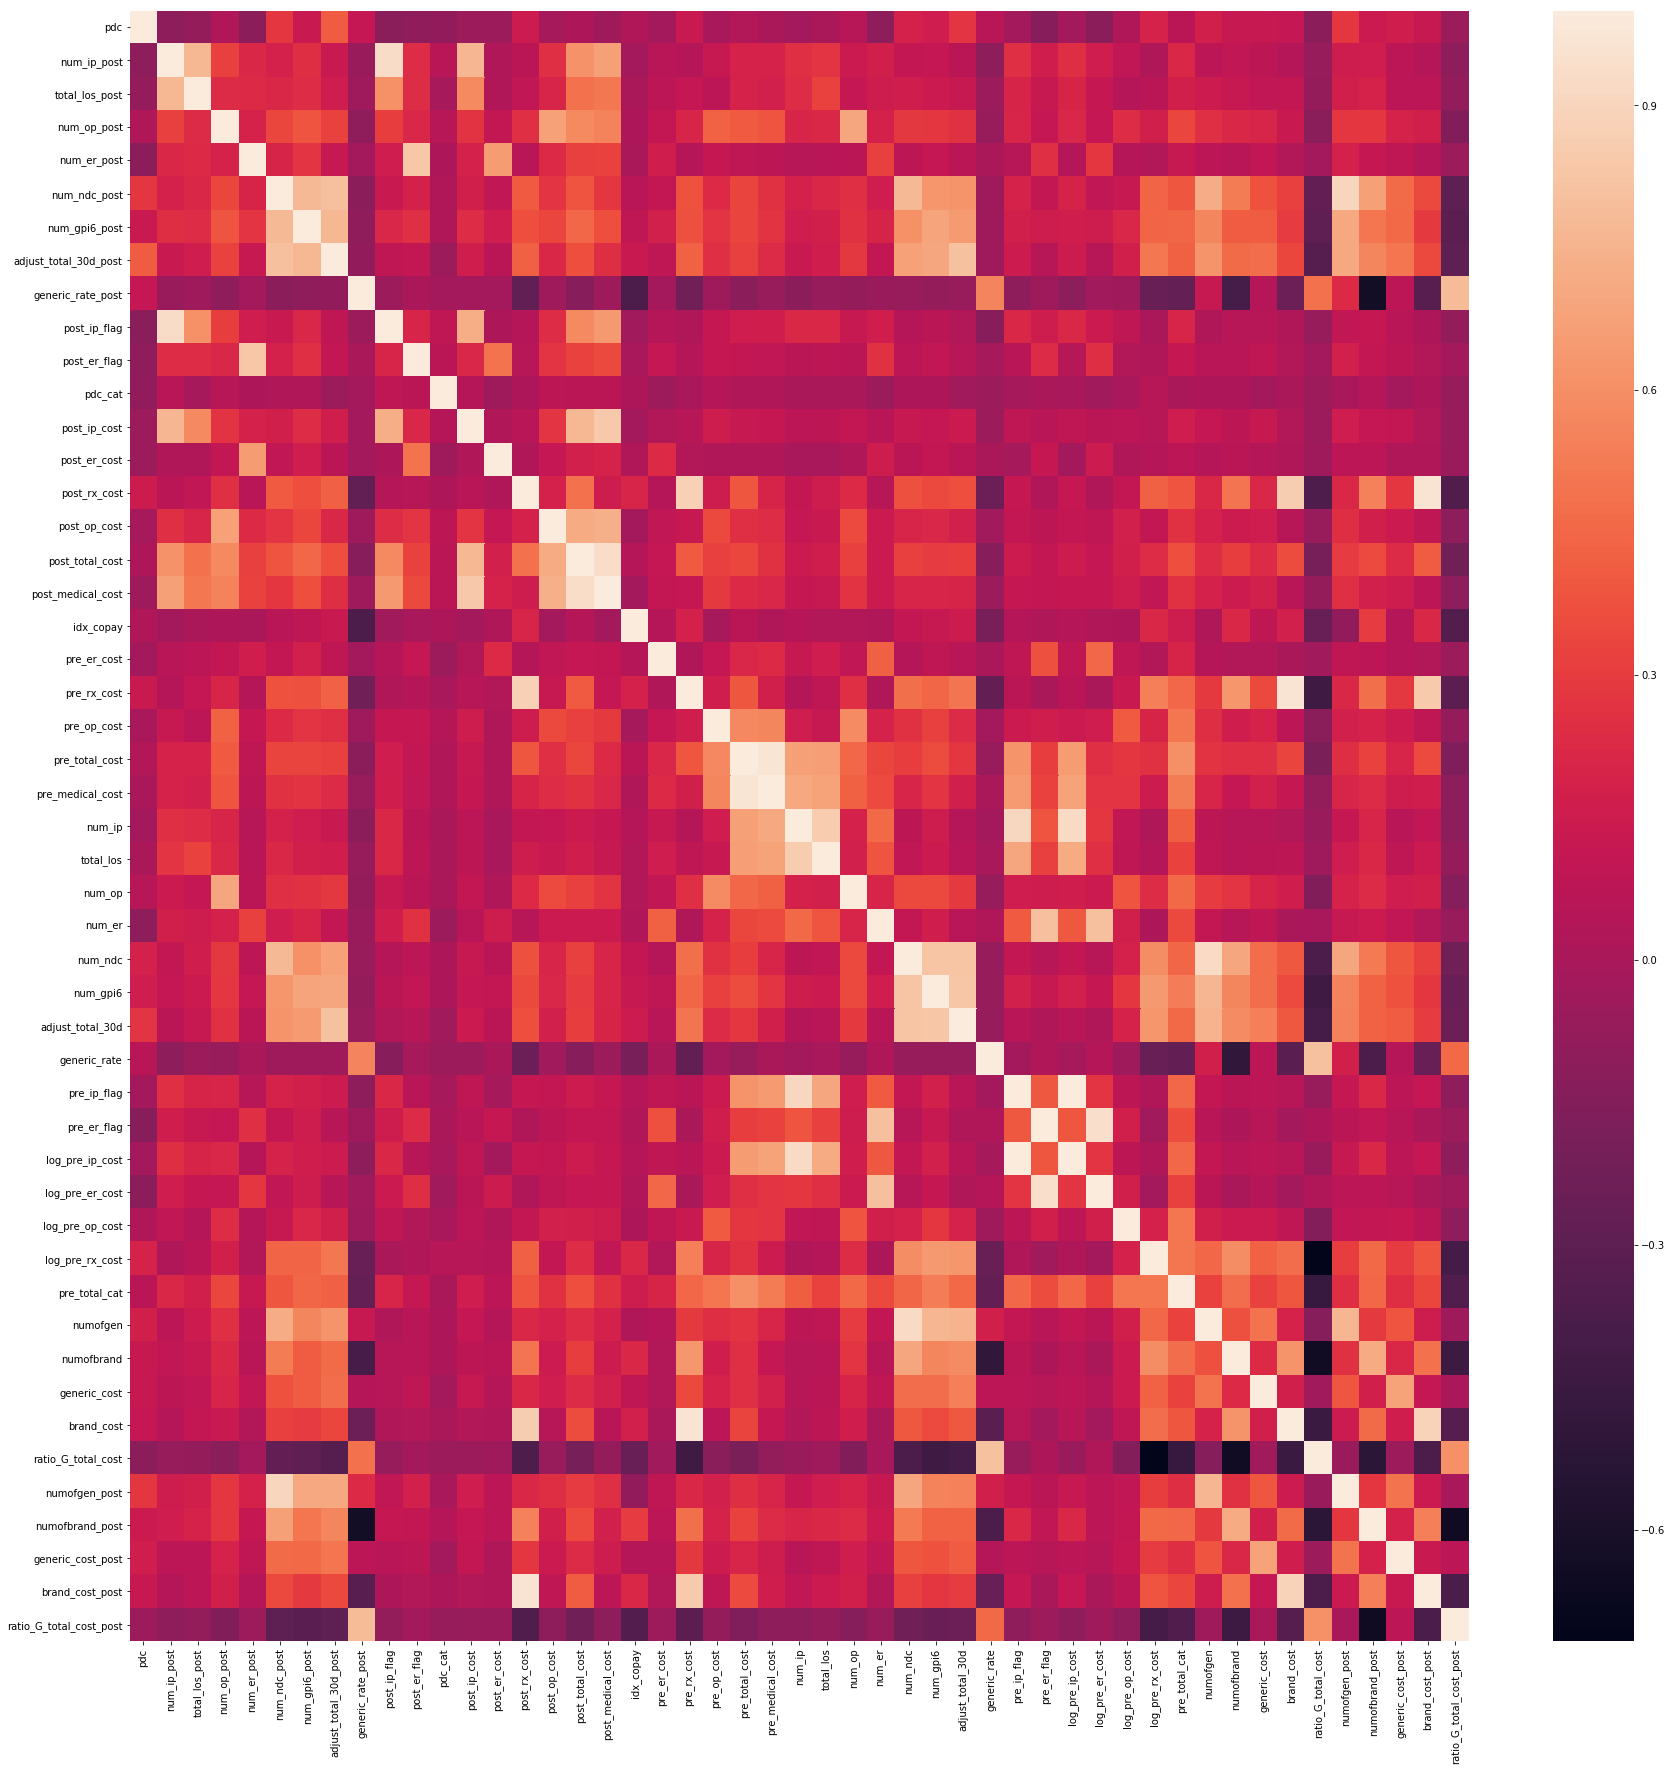

In [57]:
import seaborn as sns

plt.figure(figsize=(30,30))
corr = cont_features.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [61]:
cor_matrix = data.corr()
cor_matrix

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag
pdc,1.000000,-0.323949,-0.166131,-0.279977,-0.063338,0.168167,-0.006341,0.323417,-0.051665,-0.378714,...,0.116396,0.082020,0.070601,-0.101133,0.103482,0.202182,0.028460,0.109852,-0.129022,0.814311
num_ip_post,-0.323949,1.000000,0.674122,0.422984,0.210970,0.104027,0.187898,0.000147,0.033586,0.902454,...,0.015968,0.006695,0.029183,-0.014570,0.130095,-0.003502,0.098343,-0.010022,0.006822,-0.221230
total_los_post,-0.166131,0.674122,1.000000,0.245502,0.166701,0.110292,0.162974,0.038785,0.021241,0.538519,...,0.055378,0.014866,0.051913,-0.029822,0.114080,0.042927,0.042548,0.016255,-0.022061,-0.129790
num_op_post,-0.279977,0.422984,0.245502,1.000000,0.189553,0.255130,0.307724,0.143685,0.057500,0.426597,...,0.104528,0.086733,0.115123,-0.044069,0.277217,0.078338,0.168308,0.104238,-0.006231,-0.171229
num_er_post,-0.063338,0.210970,0.166701,0.189553,1.000000,0.184451,0.227803,0.087819,0.013566,0.141029,...,0.046430,0.038088,0.056894,-0.013331,0.191326,0.072398,0.098695,0.035323,-0.018837,-0.082584
num_ndc_post,0.168167,0.104027,0.110292,0.255130,0.184451,1.000000,0.800840,0.788000,-0.069887,0.050274,...,0.534418,0.226186,0.369600,-0.310593,0.916614,0.638020,0.177369,0.347664,-0.311136,0.147070
num_gpi6_post,-0.006341,0.187898,0.162974,0.307724,0.227803,0.800840,1.000000,0.755282,-0.053623,0.149260,...,0.448399,0.218243,0.351964,-0.327224,0.741719,0.497654,0.166595,0.292860,-0.308480,-0.008547
adjust_total_30d_post,0.323417,0.000147,0.038785,0.143685,0.087819,0.788000,0.755282,1.000000,-0.084163,-0.041802,...,0.510936,0.258099,0.387414,-0.362082,0.682455,0.578799,0.160019,0.356807,-0.324139,0.284534
generic_rate_post,-0.051665,0.033586,0.021241,0.057500,0.013566,-0.069887,-0.053623,-0.084163,1.000000,0.038629,...,-0.375802,-0.013888,-0.227544,0.429669,0.227216,-0.604109,0.104979,-0.282875,0.759175,-0.001863
post_ip_flag,-0.378714,0.902454,0.538519,0.426597,0.141029,0.050274,0.149260,-0.041802,0.038629,1.000000,...,-0.015320,-0.003079,0.008226,0.000145,0.083095,-0.042102,0.065668,-0.030362,0.016174,-0.252864


In [86]:
pd.set_option('display.max_rows', 100)
a = cor_matrix['post_medical_cost'] > .50
b = cor_matrix['post_medical_cost'][a]
b

num_ip_post          0.588214
num_op_post          0.523085
post_ip_cost         0.825682
post_op_cost         0.669415
post_total_cost      0.944803
post_medical_cost    1.000000
Name: post_medical_cost, dtype: float64

In [81]:
cor_matrix['num_op_post']['num_ip_post']

0.4229842406218677

In [99]:
names = list(b.index)
names.remove('post_medical_cost')
list_len = len(names)

for i in range(list_len):
    
    for j in range(i + 1, list_len):
        
        
        print(names[i]+" "+names[j]+ " " + str(cor_matrix[names[i]][names[j]]))
    

num_ip_post num_op_post 0.4229842406218677
num_ip_post post_ip_cost 0.6476381730579441
num_ip_post post_op_cost 0.18383960465303378
num_ip_post post_total_cost 0.5431205020494169
num_op_post post_ip_cost 0.2606838026592511
num_op_post post_op_cost 0.5764902700247471
num_op_post post_total_cost 0.5379823262600667
post_ip_cost post_op_cost 0.1410951052678846
post_ip_cost post_total_cost 0.7457854914258863
post_op_cost post_total_cost 0.6782148875093004


From our correlation heatmap, correlation matrix, we can say that num_op_post and post_total_cost are the only two variables that are highly correlated with our predictor variable, post_medical_cost, while not being correlated with the other features.

#### Examining the variables

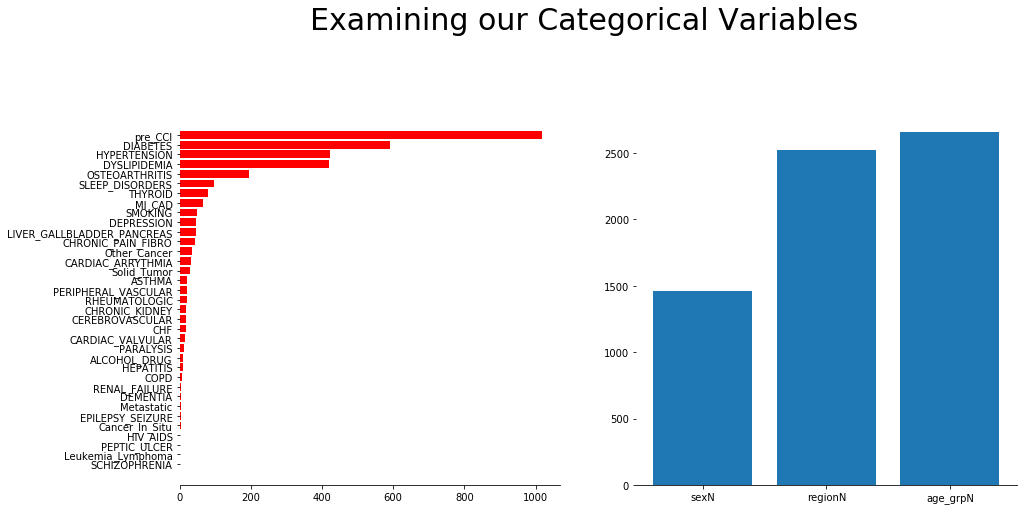

In [38]:

plt.figure(figsize=(15,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.suptitle('Examining our Categorical Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,1)

z = pd.DataFrame(all_diseases.sum())
z.columns = ['counts']
z = z.sort_values('counts',ascending=True)
plt.barh(z.index, z.counts, color = 'red')

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,2)

z1 = pd.DataFrame(othercats.sum())
z1.columns = ['counts']
z1 = z1.sort_values('counts',ascending=True)
plt.bar(z1.index, z1.counts)


sns.despine(left=True)


In [13]:
data.columns

Index(['pdc', 'num_ip_post', 'total_los_post', 'num_op_post', 'num_er_post',
       'num_ndc_post', 'num_gpi6_post', 'adjust_total_30d_post',
       'generic_rate_post', 'post_ip_flag', 'post_er_flag', 'pdc_cat',
       'post_ip_cost', 'post_er_cost', 'post_rx_cost', 'post_op_cost',
       'post_total_cost', 'post_medical_cost', 'idx_copay', 'age_grpN', 'sexN',
       'regionN', 'idx_prodtypeN', 'idx_paytypN', 'age_cat', 'log_idx_copay',
       'ALCOHOL_DRUG', 'ASTHMA', 'CARDIAC_ARRYTHMIA', 'CARDIAC_VALVULAR',
       'CEREBROVASCULAR', 'CHRONIC_KIDNEY', 'CHRONIC_PAIN_FIBRO', 'CHF',
       'COPD', 'DEMENTIA', 'DEPRESSION', 'DIABETES', 'DYSLIPIDEMIA',
       'EPILEPSY_SEIZURE', 'HEPATITIS', 'HIV_AIDS', 'HYPERTENSION',
       'LIVER_GALLBLADDER_PANCREAS', 'MI_CAD', 'OSTEOARTHRITIS', 'PARALYSIS',
       'PEPTIC_ULCER', 'PERIPHERAL_VASCULAR', 'RENAL_FAILURE', 'RHEUMATOLOGIC',
       'SCHIZOPHRENIA', 'SLEEP_DISORDERS', 'SMOKING', 'THYROID', 'Solid_Tumor',
       'Metastatic', 'Leukemia_Lymph

# 3. Data Cleaning & Feature Engineering

- **a.** Normalize the continuous variables
- **b.** Deal with outlier data? Cap it maybe
- **c.** Create new features if necessary

### (3.a) Normalizing the data

Here we look to employ the use of Guassian normalization techniques to pull our continuous variables, considering that they are not on the same scale

In [14]:
# Normalizing the continous features
scaler = preprocessing.StandardScaler().fit(cont_features)
X_scaled = scaler.transform(cont_features)

C:\Users\saxen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\saxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
X_scaled

array([[-0.25249715,  2.32385455, -0.37205094,  0.24225465, -2.40389416],
       [-0.25249715, -0.39106027, -0.37205094,  0.4139592 ,  0.58172175],
       [-0.25249715,  0.06142553, -0.37205094,  0.67151602, -0.78614934],
       ...,
       [-0.25249715,  0.06142553, -0.37205094, -0.61626808, -1.61769492],
       [-0.25249715, -0.73042462, -0.37205094, -0.61626808,  1.00296925],
       [-0.25249715,  0.06142553, -0.37205094,  1.70174329,  0.80698391]])

# 4. Feature Selection

### a. Determining the R-square or correlation co-efficient

### b. Determining Associativity

This section will focus on determining the appropriate features to incorporate in our model fitting methods. We will employ the use of various techniques to determine the following: 

- **(i)** Which features work best in creating a near optimal regression model, therefore allowing us to predict the post_index_cost variable       
    
    
- **(ii)** Which features show significant associativity which the predictor variable we will use for classification. Predicting the pdc_80_flag variable poses as a binary classification problem. 
    - Employ the use of chi-square tests to determine which categorical variables prove to be associative with 
    - Employ the use of the ________ to determine which continuous variables work best in predicting the pdc_80_flag


#### (b.i) R Squared Test

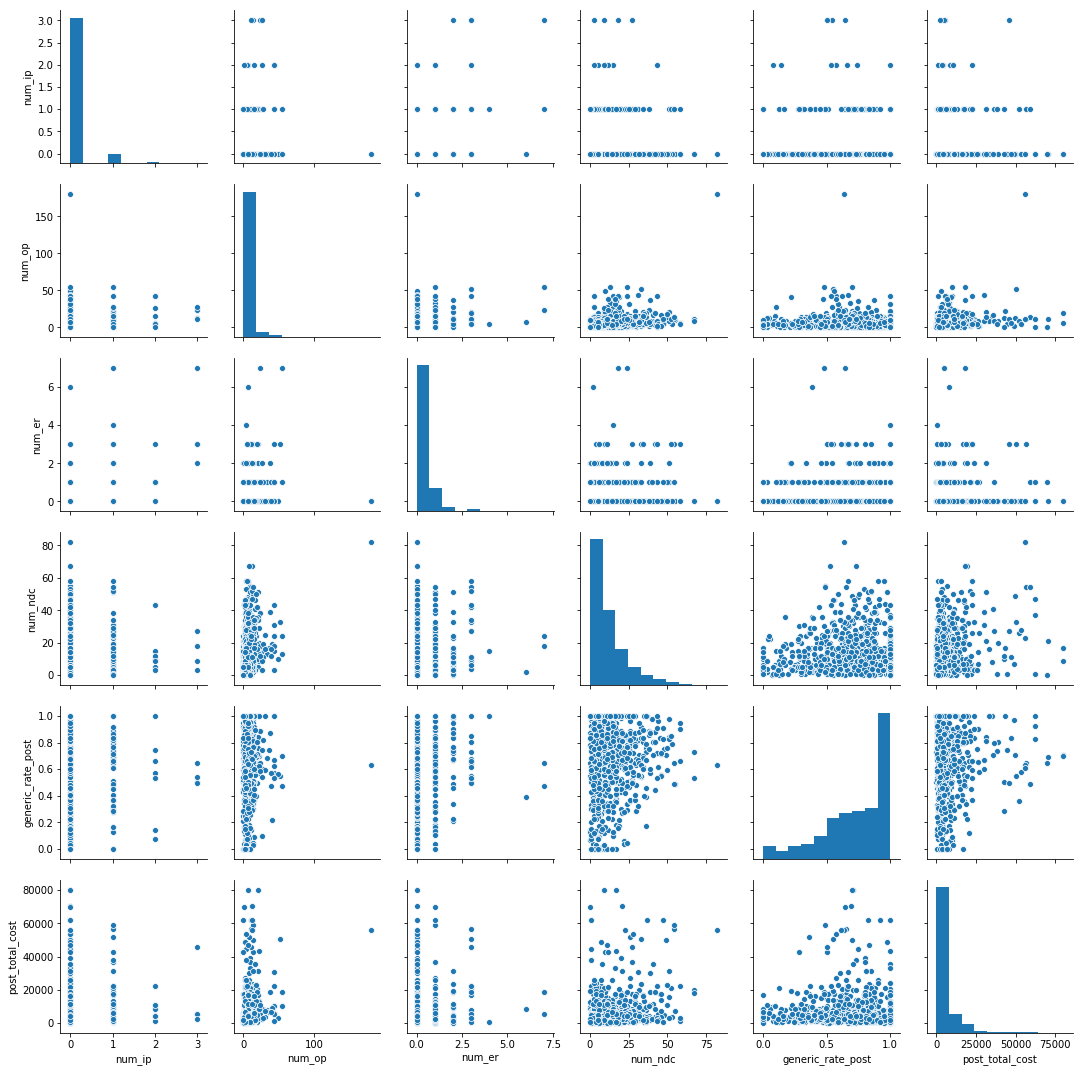

In [17]:
num_df = pd.concat([cont_features, data1['post_total_cost']], axis=1)

num_df.head(2)
ax = sns.pairplot(num_df)

#### (b.ii) Chi - Square test

In [18]:
"""Co - morbidity index"""
# First we need to make a contigency table 


def chisq(cat_cols, group, a, df):    
    """
    Calculates the chi-square metric for a set of categorical variables given the group
    
    Parameters
    ----------
    : param cat_cols: The column names of categorica columns in from the data file
    : param group: Aither ANTIDIABETIC or ANTICOAGULANT or BOTH as 'ANTIDIABETIC|ANTICOAGULANT'
    : param a: alpha test statistic
    """
    
    data = df
    
    # Only retreiving rows belonging to the group
    subset_ad = data[data['drug_class'].str.contains(group)]
    
    # Initializing empty lists to append into
    var = []
    p_val = []
    

    # Iterating over each cat_column
    for x in cat_cols:
        
        # Contingency table for that categorical column and the pdc_80_flag
        table = np.array(pd.crosstab(subset_ad[x], subset_ad['pdc_80_flag']))

        # Getting statistical metrics
        stat, p, dof, expected = chi2_contingency(table)
        
        # Append all data
        var.append(x), p_val.append(p)
    
    # Empty dataframe to append into
    mod_df = pd.DataFrame({'variable': var, 'p_val': np.round(p_val,6)})

    # return
    return mod_df[mod_df['p_val'] <= a]          


In [19]:
# Which categorical columns were chosen for Diabetic patients
cat_chosen = chisq(cat_features.columns, 'ANTIDIABETIC', 0.05, df=data1).variable
cat_chosen

11        DIABETES
12    DYSLIPIDEMIA
16    HYPERTENSION
28         THYROID
32        age_grpN
33            sexN
34         regionN
Name: variable, dtype: object

#### b.i Statistical test to choose continous features

# 5. Model Fitting - Classification

Prior to model fitting, we will create the combined dataset and then split it up the training dataset into training and validation sets in order to test for hyperparameters

In [20]:
"""Combined dataset"""

main_x = pd.concat([cont_features, cat_features], axis=1)

main_x.head(1)

,num_ip,num_op,num_er,num_ndc,generic_rate_post,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,...,SCHIZOPHRENIA,SLEEP_DISORDERS,SMOKING,THYROID,Solid_Tumor,Metastatic,Leukemia_Lymphoma,age_grpN,sexN,regionN
0,0,27,0,15,0.101382,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,3


In [49]:
# Splitting the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(main_x, data1['pdc_80_flag'], test_size=0.20, random_state=42)

In [ ]:
def return_accu_report(Xval, yval,Xtrain,ytrain, model):
    """
    returns the in and out sample accuracy rates
    """
    preds_log = model.predict(X_val)
    
    # In sample---------------------------
    # Accuracy
    in_sample_accuracy = round(accuracy_score(ytrain ,model.predict(Xtrain)),2) *100
    # Testing
    print ('The in sample accuracy score using this classifier: {} %'.format(in_sample_accuracy))

    
    
    # Out sample ----------------------
    out_preds = model.predict(Xval)
    
    # Accuracy
    out_sample_accu = round(accuracy_score(yval ,out_preds),2) *100
    # Testing
    print ('The out sample accuracy score using this classifier: {} %'.format(out_sample_accu))

    
    # Confusion matrix for the out sample
    print ('Confusion Matrix: \n' ,confusion_matrix(y_val , out_preds))

### 5.1) Classification Using Naive Bayes 

In this section we will employ the use of the Naive Bayes Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [120]:
#Create a Gaussian Classifier
nb_model = GaussianNB()

# Fitting the Model
nb_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train, y_train, nb_model)    

The in sample accuracy score using this classifier: 63.0 %
The out sample accuracy score using this classifier: 62.0 %
Confusion Matrix: 
 [[96 20]
 [54 23]]


### 5.2) Logistic Regression

In this section we will employ the use of the Logistic Regression Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [119]:
# creating an instance of the model AND fitting it 
log_model = LogisticRegression(random_state=0, penalty="l2", max_iter = 1000, solver = 'lbfgs')

# Fitting the Model
log_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train, y_train, log_model)    

The in sample accuracy score using this classifier: 66.0 %
The out sample accuracy score using this classifier: 64.0 %
Confusion Matrix: 
 [[99 17]
 [52 25]]


### 5.3) KNN

In this section we will employ the use of the KNN to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [117]:
# Initializing the model
neigh = KNeighborsClassifier(n_neighbors=3, weights = 'distance')

# fitting the model 
neigh.fit(X_train, y_train)

return_accu_report(X_val, y_val,X_train, y_train, neigh)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 62.0 %
Confusion Matrix: 
 [[85 31]
 [43 34]]


In [122]:
X_train.shape

(772, 40)